# Autoencoder for MNIST compared to supervised model

### Imports and load the MNIST dataset

In [71]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Exstract input shape
input_shape = x_train.shape[1:] # (28, 28)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


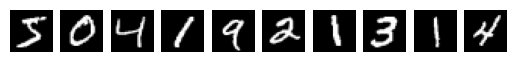

In [72]:
# Plot the first 10 images
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')

In [75]:
# Add noise to the images
noise_factor = 0.3
x_train_noise = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noise = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

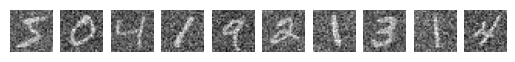

In [76]:
# Print the same 10 images with noise
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train_noise[i], cmap='gray')
    plt.axis('off')

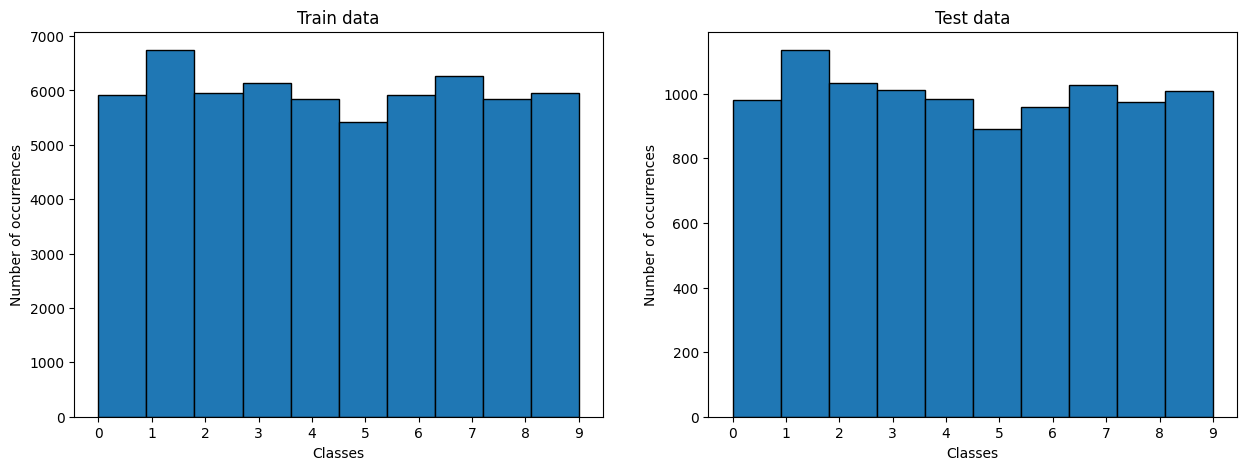

In [77]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
axs[0].hist(y_train, ec='black')
axs[0].set_title('Train data')
axs[0].set_xlabel('Classes') 
axs[0].set_ylabel('Number of occurrences')
axs[1].hist(y_test, ec='black')
axs[1].set_title('Test data')
axs[1].set_xlabel('Classes') 
axs[1].set_ylabel('Number of occurrences')
# We want to show all ticks...
axs[0].set_xticks(np.arange(10))
axs[1].set_xticks(np.arange(10))

plt.show()

### Vector size for latent variables and number of epochs

In [78]:
LATENT_SIZE = 32
EPOCHS_UNSUPERVISED = 10
EPOCHS_SUPERVISED = 50

### Define the autoencoder model consisting of an encoder and decoder

In [118]:
# Autoencoder using Dense layers and batch normalization
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(LATENT_SIZE, activation="relu")
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(784, activation="sigmoid"),
    tf.keras.layers.Reshape(input_shape)
])

img = tf.keras.layers.Input(shape = input_shape)
latent_vector = encoder(img)
output = decoder(latent_vector)
autoencoder = tf.keras.models.Model(inputs = img, outputs = output)

### Compile and train the autoencoder

In [ ]:
autoencoder.compile("adam", loss = "mean_squared_error")

history = autoencoder.fit(x_train_noise, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test))

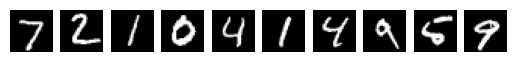

In [81]:
# Plot the 10 first images in the test set
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')

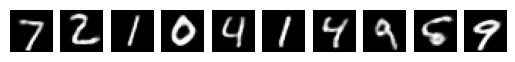

In [82]:
# Predict the first 10 images for the test set
predicted = autoencoder.predict(x_test[:10], verbose=0)

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(predicted[i], cmap='gray')
    plt.axis('off')


### Plot the autoencoder loss

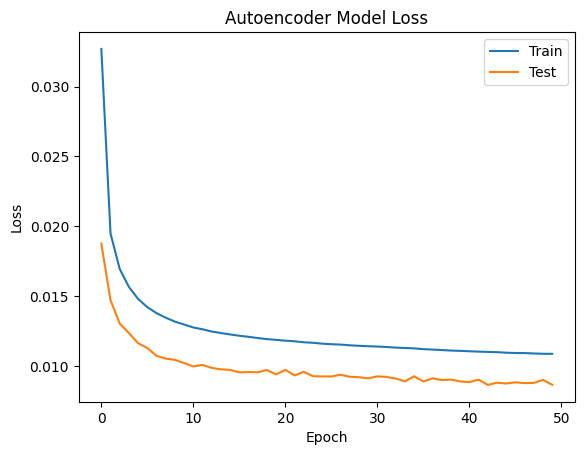

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [108]:
# Test accuracy of the encoder before fine-tuning
added_layer = tf.keras.layers.Dense(10, activation="softmax")
model = tf.keras.models.Sequential([encoder, added_layer])
model.compile("adam", loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy before fine-tuning: ", acc)

Accuracy before fine-tuning:  0.10670000314712524


In [84]:
# Save the encoder part of the autoencoder
encoder.save('../models/encoder.h5')
decoder.save('../models/decoder.h5')
autoencoder.save('../models/autoencoder.h5')

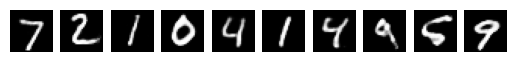

In [66]:
# Testing if model can be tranfered
encoder = tf.keras.models.load_model('../models/encoder.h5')
decoder = tf.keras.models.load_model('../models/decoder.h5')

autoencoder = tf.keras.models.Sequential([encoder, decoder])
autoencoder.compile("adam", loss = "mean_squared_error")

# Plot the 10 first images in the test set
predicted = autoencoder.predict(x_test[:10], verbose=0)

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(predicted[i], cmap='gray')
    plt.axis('off')


### Fine-tune the model with supervised learning with 10% of the training data

(600, 28, 28)
(600,)


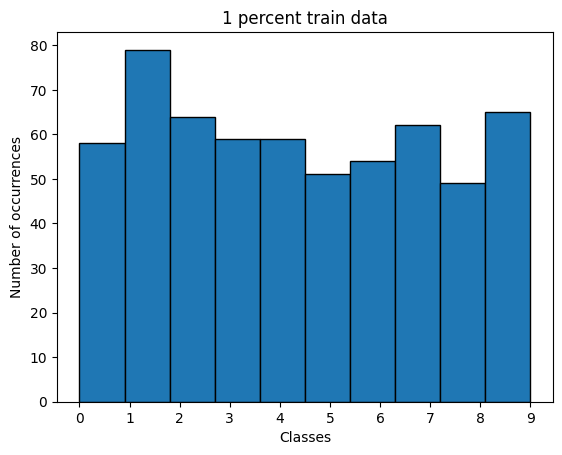

In [85]:
# Use 1% of the labeled training examples for supervised learning
x_train_supervised = x_train[:600]
y_train_supervised = y_train[:600]

print(x_train_supervised.shape)
print(y_train_supervised.shape)

plt.plot(figsize=(10,5)) 
plt.hist(y_train_supervised, ec='black')
plt.title('1 percent train data')
plt.xlabel('Classes') 
plt.ylabel('Number of occurrences')
plt.xticks(np.arange(10))
plt.show()

In [86]:
# Get the saved encoder
encoder_model = tf.keras.models.load_model('../models/encoder.h5')

# Set up the model
fine_tune_model = tf.keras.models.Sequential([
    encoder_model,
    tf.keras.layers.Dense(10, activation="softmax")
])

fine_tune_model.summary()

# Compile the model
fine_tune_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model
history_autoencoder = fine_tune_model.fit(
    x_train_supervised,
    y_train_supervised,
    epochs=10,
)

# Evaluate the model on the test set
_, accuracy_autoencoder = fine_tune_model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy after fine-tuning: {accuracy_autoencoder}")

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_30 (Sequential)  (None, 32)                110816    
                                                                 
 dense_57 (Dense)            (None, 10)                330       
                                                                 
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
19/19 [==============================] - 1s 3ms/step - loss: 3.6468 - accuracy: 0.2233
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 1.3538 - accuracy: 0.5333
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.8438 - accuracy: 0.7517
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.6294 - accuracy: 0.8133
Epoch 5/10
19/19 [==============================] -

## Training a FNN model supervised on 1% of the labeled data

In [87]:
# Set up the model using dense layers
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history_cnn = cnn_model.fit(
    x_train_supervised,
    y_train_supervised,
    epochs=10,
)

# Evaluate the model on the test set
_, accuracy_cnn = cnn_model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy : {accuracy_cnn}")

Epoch 1/10
19/19 [==============================] - 1s 3ms/step - loss: 1.9778 - accuracy: 0.3417
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 1.1370 - accuracy: 0.7517
Epoch 3/10
19/19 [==============================] - 0s 3ms/step - loss: 0.6451 - accuracy: 0.8300
Epoch 4/10
19/19 [==============================] - 0s 3ms/step - loss: 0.4090 - accuracy: 0.9050
Epoch 5/10
19/19 [==============================] - 0s 3ms/step - loss: 0.2953 - accuracy: 0.9217
Epoch 6/10
19/19 [==============================] - 0s 3ms/step - loss: 0.2196 - accuracy: 0.9483
Epoch 7/10
19/19 [==============================] - 0s 3ms/step - loss: 0.1702 - accuracy: 0.9717
Epoch 8/10
19/19 [==============================] - 0s 2ms/step - loss: 0.1279 - accuracy: 0.9883
Epoch 9/10
19/19 [==============================] - 0s 2ms/step - loss: 0.0954 - accuracy: 0.9917
Epoch 10/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0757 - accuracy: 0.9950
Accuracy : 0.860499

In [35]:
# Save the model
cnn_model.save('../models/cnn_model.h5')

### Plot the history accuracy of the two models

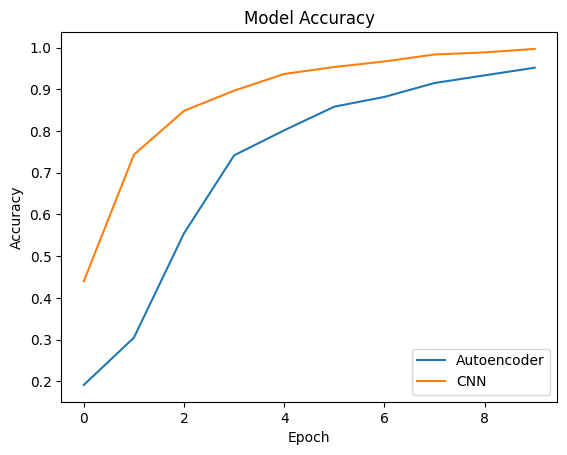

In [55]:
plt.plot(history_autoencoder.history['accuracy'])
plt.plot(history_cnn.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'CNN'], loc='lower right')
plt.show()

### Compare the performance of the autoencoder and FNN models

In [39]:
print(f'Unsupervised CNN autoencoder with supervised fine-tuning accuracy: {accuracy_autoencoder}')
print(f'Supervised CNN accuracy: {accuracy_cnn}')
print()

if accuracy_autoencoder > accuracy_cnn:
    print(f'Unsupervised autoencoder with supervised fine-tuning performs better after {EPOCHS_UNSUPERVISED} unsupervised ephocs, and {EPOCHS_SUPERVISED} supervised epochs.')
else:
    print(f'Supervised FNN is better after {EPOCHS_SUPERVISED} supervised epochs')

Unsupervised CNN autoencoder with supervised fine-tuning accuracy: 0.8639000058174133
Supervised CNN accuracy: 0.8605999946594238

Unsupervised CNN autoencoder with supervised fine-tuning performs better after 10 unsupervised ephocs, and 10 supervised epochs.


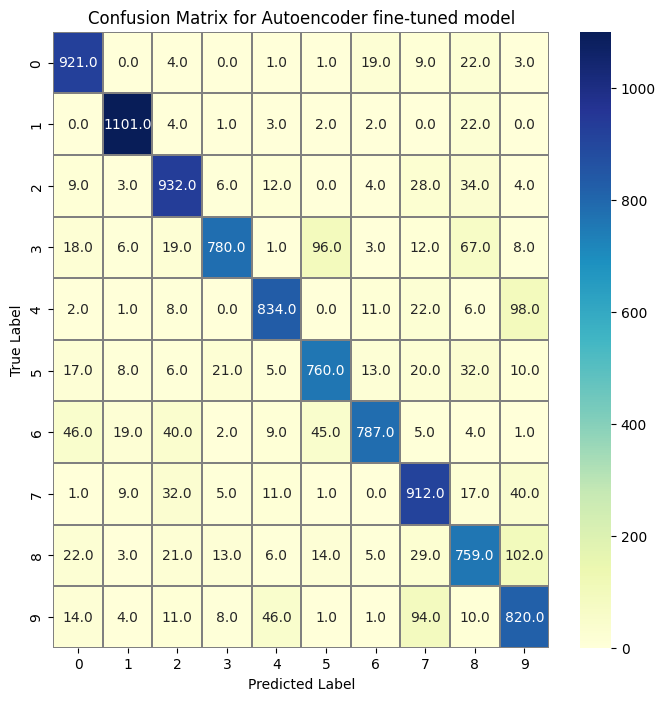

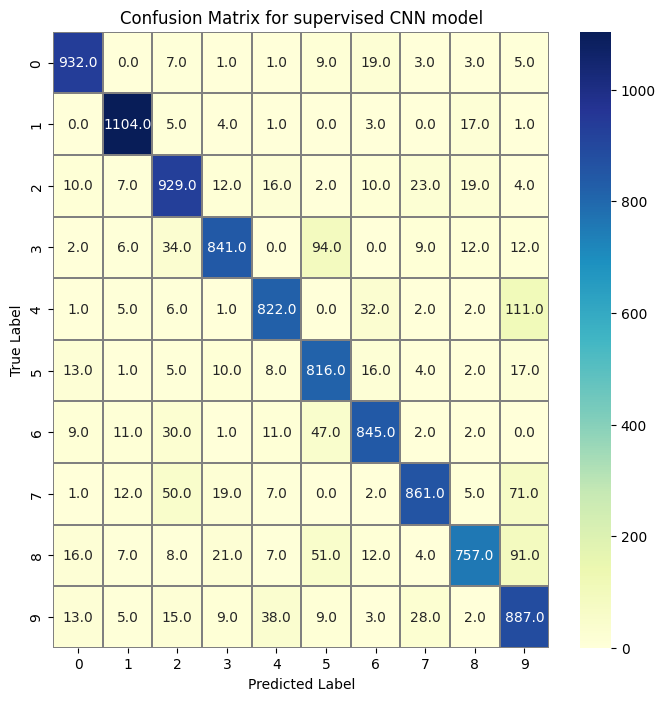

In [131]:
# Seaborn heatmap of confusion matrix

# Predict the values from the validation dataset
Y_pred = fine_tune_model.predict(x_test, verbose=0)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = y_test

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="YlGnBu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Autoencoder fine-tuned model")


# Predict the values from the validation dataset
Y_pred = cnn_model.predict(x_test, verbose=0)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = y_test

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="YlGnBu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for supervised CNN model")
plt.show()